In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arjuntejaswi/plant-village
!unzip plant-village.zip
!rm plant-village.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Cur

In [12]:
import os
import shutil

# Source and destination directories
source_dir = "/content/PlantVillage"
destination_dir = "/content/Plant_Village"

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# List of specific items to copy
items_to_copy = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]

# Copy the specified items
for item in items_to_copy:
    source_path = os.path.join(source_dir, item)
    destination_path = os.path.join(destination_dir, item)
    if os.path.exists(source_path):
        if os.path.isdir(source_path):
            shutil.copytree(source_path, destination_path, dirs_exist_ok=True)  # Copy directories
        else:
            shutil.copy2(source_path, destination_path)  # Copy files
        print(f"Copied: {source_path} -> {destination_path}")
    else:
        print(f"Item not found: {source_path}")


Copied: /content/PlantVillage/Potato___Early_blight -> /content/Plant_Village/Potato___Early_blight
Copied: /content/PlantVillage/Potato___Late_blight -> /content/Plant_Village/Potato___Late_blight
Copied: /content/PlantVillage/Potato___healthy -> /content/Plant_Village/Potato___healthy


In [13]:
target_dir = "/content/Plant_Village"

In [47]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [15]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [16]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    target_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [17]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [18]:
len(dataset)

68

In [19]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 1 0 0 1 0 0 1 0 1 0 2 2 1 0 2 0 1 0 1 0 0 1 0 1 1 0 0 1]


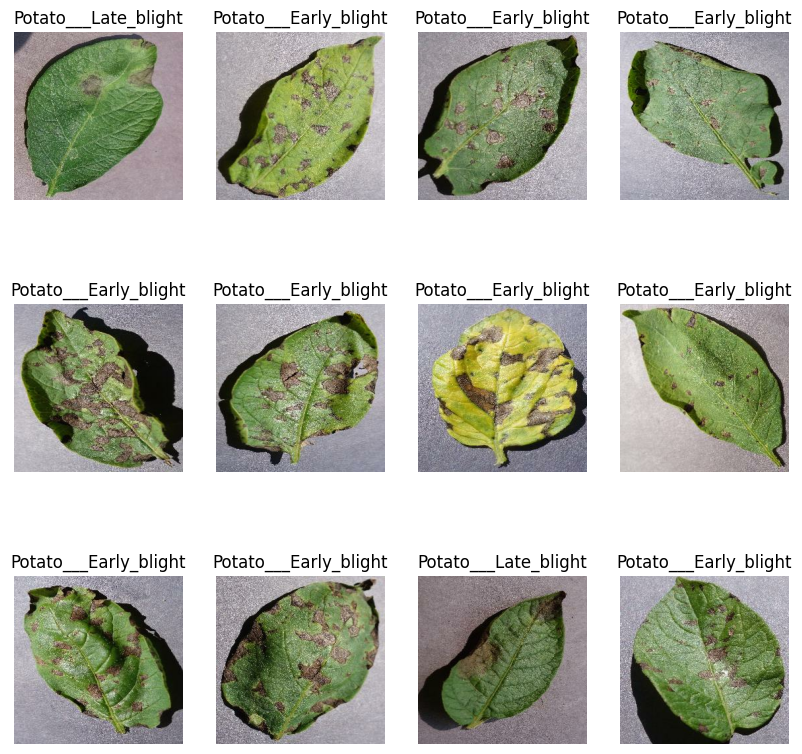

In [20]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

- 80% -> training
- 20% -> 10% validation, 10% test

In [21]:
trian_size = 0.8
len(dataset) * trian_size

54.400000000000006

In [22]:
train_ds = dataset.take(54)
len(train_ds)

54

In [23]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [24]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [25]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [26]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [27]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=13)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [29]:
len(train_ds)

54

In [30]:
len(val_ds)

6

In [31]:
len(test_ds)

8

In [32]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [56]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [57]:
data_augumentaion = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [72]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    resize_and_rescale,
    data_augumentaion,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])


In [73]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_18 (Sequential)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_19 (Sequential)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_87 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_87 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_88 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_88 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_89 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_89 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_90 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_90 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_91 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_91 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_92 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_92 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [75]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds

)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.4425 - loss: 0.9904 - val_accuracy: 0.5521 - val_loss: 0.8823
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5443 - loss: 0.9055 - val_accuracy: 0.5885 - val_loss: 1.1026
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7150 - loss: 0.6675 - val_accuracy: 0.7552 - val_loss: 0.5845
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7918 - loss: 0.5039 - val_accuracy: 0.8281 - val_loss: 0.4457
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8330 - loss: 0.4073 - val_accuracy: 0.8021 - val_loss: 0.4039
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8564 - loss: 0.3475 - val_accuracy: 0.8958 - val_loss: 0.2409
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8990 - loss: 0.2487 - val_accuracy: 0.8958 - val_loss: 0.2232
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9088 - loss: 0.2281 - val_accuracy: 0.9062 - 

In [76]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9854 - loss: 0.0463


[0.054728079587221146, 0.9784482717514038]

In [77]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [78]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

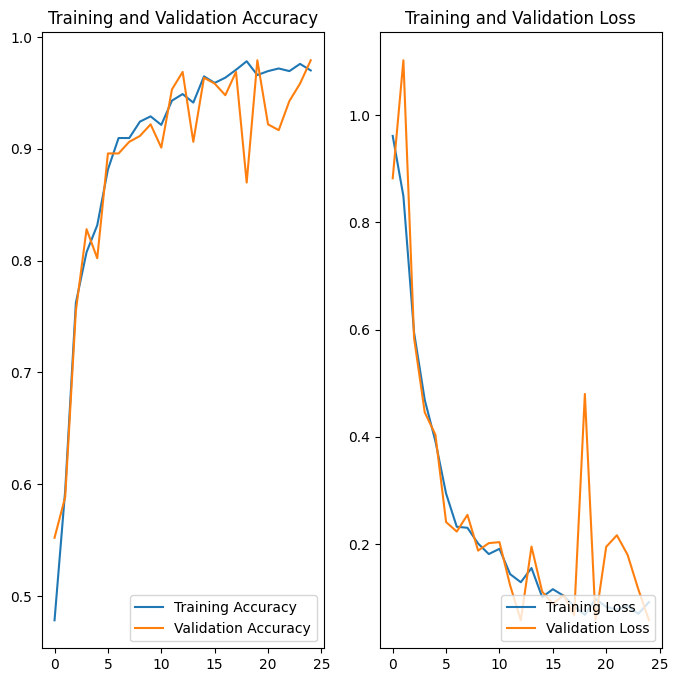

In [80]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")

First image to predict
Actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction label: Potato___Late_blight


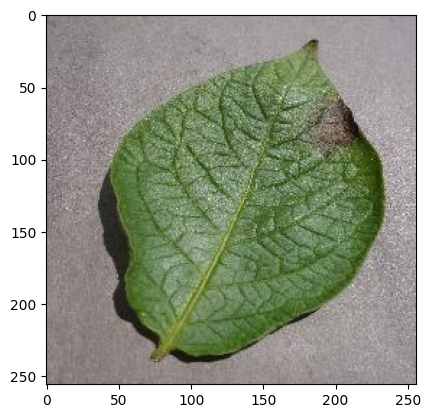

In [83]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[5].numpy().astype('uint8')
    first_label = labels_batch[5].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Prediction label:", class_names[np.argmax(batch_prediction[0])])

In [84]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


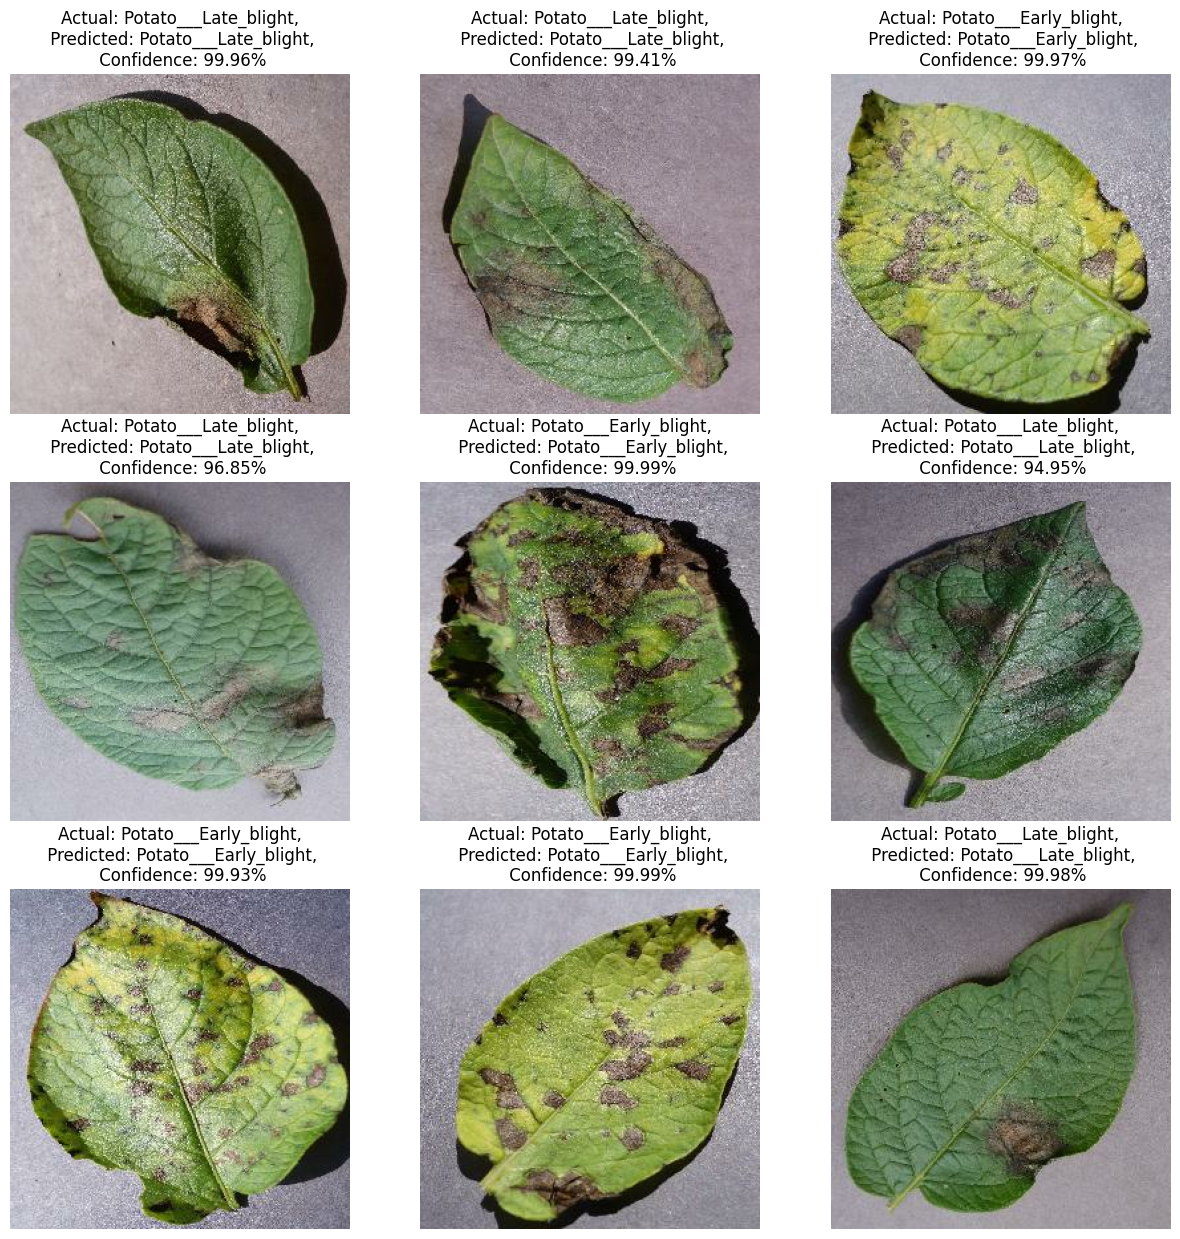

In [86]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")

        plt.axis("off")

In [87]:
model_version = 1
model.save(f"/content/Plant_Village/{model_version}.keras")
